python code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 19 15:36:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 28 15:54:39 2022
"""

from sklearn.utils import shuffle
import pandas as pd
import seaborn as sns
from math import sqrt
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,Input, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, MaxPooling1D, Conv1D, Flatten, LeakyReLU, Activation, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import datetime
from pandas import Series
from numpy.random import randn
import os
import random as rn
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from tensorflow.keras import backend as t
from tensorflow.keras.layers import Embedding, Masking
from tensorflow.keras.utils import to_categorical

**Creating input data for our model**

In [4]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sine_samples = []
data = []
fs = 32000 #sampling rate
Ts = 1/fs #time duration
#t=0.1 
freqList = [250, 500, 750 , 1000, 1500, 2000, 3000, 4000, 6000] 
#n = np.linspace(0,1,2048) #no of samples
n = np.arange(0, 2048, 1) #no of samples
print("number of samples is = ", n)
''''noise = np.random.normal(0, 1, size = (2048,)) 
phase = 2* np.pi *np.random.random(1)
for freq in freqList:
    for i in range(10):
        y = np.sin(2* np.pi * freq *n * Ts + phase) + noise
        sine_samples.append(y)

plt.figure(figsize = (8, 6))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.plot(n,y)
#plt.savefig('Sinewave.png'.format(freq))
plt.show()

train_data = np.array(sine_samples)  
num_samples = len(train_data)
print(num_samples)
print(train_data.shape)'''

number of samples is =  [   0    1    2 ... 2045 2046 2047]


'\'noise = np.random.normal(0, 1, size = (2048,)) \nphase = 2* np.pi *np.random.random(1)\nfor freq in freqList:\n    for i in range(10):\n        y = np.sin(2* np.pi * freq *n * Ts + phase) + noise\n        sine_samples.append(y)\n\nplt.figure(figsize = (8, 6))\nplt.xlabel("Time")\nplt.ylabel("Amplitude")\nplt.grid(True)\nplt.plot(n,y)\n#plt.savefig(\'Sinewave.png\'.format(freq))\nplt.show()\n\ntrain_data = np.array(sine_samples)  \nnum_samples = len(train_data)\nprint(num_samples)\nprint(train_data.shape)'


**New Part of the code to creating the input noisy data, with random phase.**



In [5]:
#alpha = 0.2
for freq in freqList:
   list_phi=[]
   for _ in range(10000):
       phi = np.random.rand()*(2*np.pi)
       list_phi.append(phi)
   for phases in range(len(list_phi)):
       alpha = np.random.uniform(0.1,5)
       #print (alpha)
       wave = np.sin(2* np.pi * freq * n / fs + phases)
       noise = alpha * np.random.normal(0, 1, size = (2048,))
       signal = wave + noise
       sine_samples.append(signal)

train_data = np.array(sine_samples)  
num_samples = len(train_data)
print(num_samples)
print(train_data.shape)

90000
(90000, 2048)


In [6]:
from tensorflow import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)

2.8.0
2.8.0


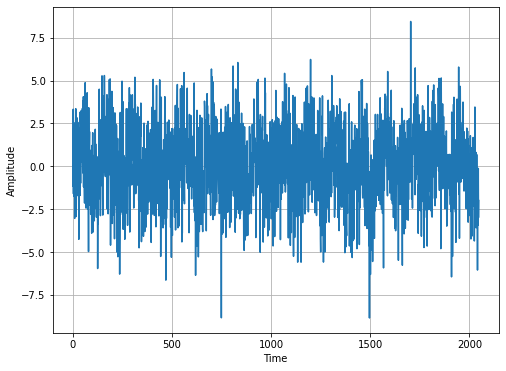

In [7]:
plt.figure(figsize = (8, 6))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.plot(train_data[100])
#plt.savefig('Sinewave.png'.format(freq))
plt.show()

**Labeling the input data**

*   List Label
*   List Categorical



In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
label1=np.ones((num_samples),dtype = int)
label1[0:9999]= 0
label1[10000:19999] = 1
label1[20000:29999] = 2
label1[30000:39999] = 3
label1[40000:49999] = 4
label1[50000:59999] = 5
label1[60000:69999] = 6
label1[70000:79999] = 7
label1[80000:89999] = 8

num_classes = 9
Y=to_categorical(label1, num_classes)


Normalize the input data as pre-processing


*   Normalization by standard deviation
*   Split our data to Train/Test



In [9]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def Normalize(data):
    mean_data=np.mean(data)
    std_data=np.std(data)
    norm_data=(data-mean_data)/std_data
    return norm_data

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
x_train,x_test,y_train,y_test=train_test_split(train_data, Y, test_size=0.2,random_state=2)
x_train=Normalize(x_train)
x_test=Normalize(x_test)

Defining some parameters settings as well as creating the LSTM model

LSTM Model


In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
n_units=[64, 128, 256]
n_epochs=50
batch_size = 100
data_shape = (2048, 1)
filters = [16, 32, 64, 128, 256]
model = Sequential()
#model.add(LSTM(n_units, input_shape = data_shape))
#model.add(Masking( mask_value=0, batch_input_shape=(batch_size, data_shape[0], data_shape[1])))
model.add(Conv1D(filters[0], kernel_size=3, padding='same', strides = 1,
                 batch_input_shape=(batch_size, data_shape[0], data_shape[1])))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[1], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[2], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[3], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[4], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(LSTM(n_units[0], return_sequences=True))
model.add(Activation('relu'))

model.add(LSTM(n_units[1], return_sequences=True))
model.add(Activation('relu'))

model.add(LSTM(n_units[2]))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test),  batch_size= batch_size, epochs=n_epochs, shuffle=False)

Epoch 1/50
720/720 [==============================] - 431s 577ms/step - loss: 2.1980 - accuracy: 0.1121 - val_loss: 2.1978 - val_accuracy: 0.1094
Epoch 2/50
720/720 [==============================] - 427s 593ms/step - loss: 2.2000 - accuracy: 0.1108 - val_loss: 2.1977 - val_accuracy: 0.1094
Epoch 3/50
720/720 [==============================] - 430s 597ms/step - loss: 2.1968 - accuracy: 0.1137 - val_loss: 2.1999 - val_accuracy: 0.1109
Epoch 4/50
720/720 [==============================] - 428s 595ms/step - loss: 2.1587 - accuracy: 0.1379 - val_loss: 2.1026 - val_accuracy: 0.1407
Epoch 5/50
720/720 [==============================] - 432s 600ms/step - loss: 2.0232 - accuracy: 0.1780 - val_loss: 1.8416 - val_accuracy: 0.2066
Epoch 6/50
720/720 [==============================] - 432s 601ms/step - loss: 1.8243 - accuracy: 0.2597 - val_loss: 1.5488 - val_accuracy: 0.3707
Epoch 7/50
720/720 [==============================] - 432s 601ms/step - loss: 1.4389 - accuracy: 0.4425 - val_loss: 1.1077 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


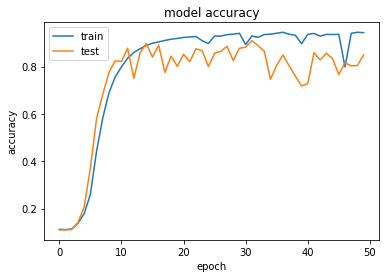

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

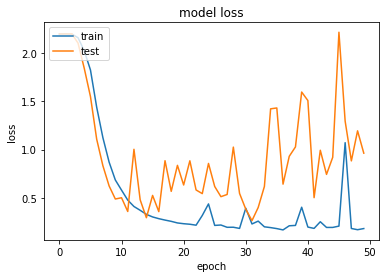

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[6.4702527e-12 1.0242303e-13 1.2712647e-08 ... 1.0094082e-08
  4.6934350e-08 2.3388975e-05]
 [4.9641670e-07 5.6926721e-09 4.2770094e-05 ... 1.3912781e-04
  1.3060991e-02 1.3306744e-01]
 [2.3238982e-16 1.3486424e-16 3.5515724e-09 ... 6.8453021e-12
  1.9213961e-10 1.6464384e-09]
 ...
 [3.6645826e-21 1.1682512e-19 1.9414846e-21 ... 8.4719978e-19
  7.7796304e-17 6.7120794e-13]
 [9.9877542e-01 4.7591658e-07 6.3892229e-09 ... 5.1656212e-07
  2.7457576e-05 1.1958354e-03]
 [1.1592419e-11 9.9999809e-01 9.1401674e-08 ... 3.7525708e-11
  3.9005894e-08 1.7334332e-06]]
              precision    recall  f1-score   support

       (250)       1.00      0.74      0.85      2001
       (500)       1.00      0.72      0.84      2014
       (750)       1.00      0.82      0.90      2078
      (1000)       1.00      0.90      0.95      2057
      (1500)       1.00      0.76      0.86      1970
      (2000)       1.00      0.89      0.94      1971
      (3000)       1.00      0.89      0.94      1976
   

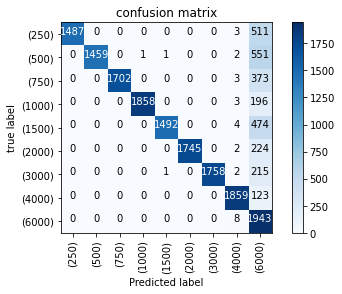

In [13]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
    print(cm)
    thresh=cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')


Y_pred =model.predict(x_test,batch_size=batch_size,verbose=0)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#y_pred = model.predict_classes(x_test, batch_size=batch_size, verbose=0)
target_names = ['(250)','(500)','(750)', '(1000)','(1500)','(2000)', '(3000)', '(4000)', '(6000)']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
cnf_matrix=(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
plot_confusion_matrix(cnf_matrix, classes=target_names, title='confusion matrix')

**Defining some parameters settings as well as creating the Bidirectional model**

*   Bidirectional *model*



In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
n_units=[64, 128, 256]
n_epochs=50
batch_size = 100
data_shape = (2048, 1)
filters = [16, 32, 64, 128, 256]
model = Sequential()
#model.add(LSTM(n_units, input_shape = data_shape))
#model.add(Masking( mask_value=0, batch_input_shape=(batch_size, data_shape[0], data_shape[1])))
model.add(Conv1D(filters[0], kernel_size=3, padding='same', strides = 1,
                 batch_input_shape=(batch_size, data_shape[0], data_shape[1])))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[1], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[2], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[3], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters[4], kernel_size=3, strides = 1, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

'''
**********************************************************************************
**********************************************************************************
**********************************************************************************
The states/gates of the previous cell is used to calculate the state of the 
current cell. In keras if stateful=False then the states are reset after 
each batch. If stateful=True the states from the previous batch for index
 i will be used as initial state for index i in the next batch. So state 
 information get propagated between batches with stateful=True.
**********************************************************************************
**********************************************************************************
**********************************************************************************
'''

model.add(Bidirectional(LSTM(n_units[0], stateful=True, return_sequences= True)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Bidirectional(LSTM(n_units[1], stateful=True, return_sequences= True)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Bidirectional(LSTM(n_units[2], stateful=True, return_sequences= False)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test,y_test),  batch_size= batch_size, epochs=n_epochs, shuffle=False)

Epoch 1/80
720/720 [==============================] - 889s 1s/step - loss: 2.1983 - accuracy: 0.1103 - val_loss: 2.1977 - val_accuracy: 0.1094
Epoch 2/80
390/720 [===============>..............] - ETA: 6:11 - loss: 2.1983 - accuracy: 0.1118

KeyboardInterrupt: ignored

In [ ]:


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix without normalization")
    print(cm)
    thresh=cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",
        color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')


Y_pred =model.predict(x_test,batch_size=batch_size,verbose=0)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#y_pred = model.predict_classes(x_test, batch_size=batch_size, verbose=0)
target_names = ['(250)','(500)','(750)', '(1000)','(1500)','(2000)', '(3000)', '(4000)', '(6000)']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))
cnf_matrix=(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
plot_confusion_matrix(cnf_matrix, classes=target_names, title='confusion matrix')
